In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [3]:
class CELUlike(nn.Module):
    def __init__(self, alpha=1.0, beta=1.0):
        super().__init__()
        self.alpha = alpha  # 可自定义的参数（如修改默认α）
        self.beta = beta    # 扩展功能参数（按需添加）

    def forward(self, x):
        # 核心逻辑：基于PyTorch原生CELU的修改
        positive = torch.max(torch.zeros_like(x), x)
        negative = self.alpha * (torch.exp(x / self.alpha) - 1)
        nega4 = 4 - self.alpha * (torch.exp((4-x) / self.alpha) - 1)
        return torch.where(x>0,torch.where(x>4,nega4,positive),negative)

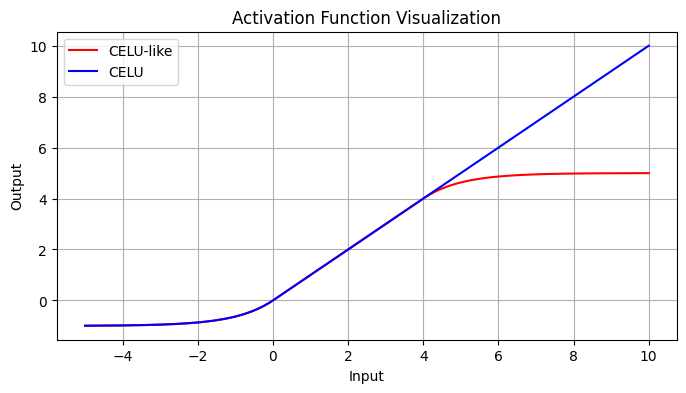

In [4]:
x = torch.linspace(-5, 10, 200)  # 生成200个等间距点
x_np = x.detach().numpy()       # 转为NumPy数组供Matplotlib使用
celulike = CELUlike()
y = celulike(x).detach().numpy()  # 计算并转为NumPy
y2 = F.celu(x).detach().numpy()

plt.figure(figsize=(8, 4))
plt.plot(x_np, y, 'r-', label='CELU-like')
plt.plot(x_np, y2, 'b-', label='CELU')
plt.title("Activation Function Visualization")
plt.xlabel("Input"), plt.ylabel("Output")
plt.grid(True), plt.legend()
plt.show()

MNIST

In [5]:
# 定义使用 CELU-like 的卷积网络
class CELULikeConvNet(nn.Module):
    def __init__(self):
        super(CELULikeConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(32 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
        self.activation = CELUlike()

    def forward(self, x):
        x = self.activation(self.conv1(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = self.activation(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = x.view(x.size(0), -1)
        x = self.activation(self.fc1(x))
        x = self.fc2(x)
        return x

# 定义使用 CELU 的卷积网络
class CELUConvNet(nn.Module):
    def __init__(self):
        super(CELUConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(32 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.celu(self.conv1(x), alpha=1.0)
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = F.celu(self.conv2(x), alpha=1.0)
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = x.view(x.size(0), -1)
        x = F.celu(self.fc1(x), alpha=1.0)
        x = self.fc2(x)
        return x

In [6]:
# 数据预处理
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# 加载 MNIST 数据集
train_dataset = datasets.MNIST(root='data', train=True, download=False, transform=transform)
test_dataset = datasets.MNIST(root='data', train=False, download=False, transform=transform)

# 从训练集中划分一小部分作为验证集
train_size = int(0.9 * len(train_dataset))  # 90% 作为训练集
val_size = len(train_dataset) - train_size  # 10% 作为验证集
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# 数据加载器
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1000, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CELULikeConvNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# 用于保存训练损失和验证准确率
train_losses = []
val_accuracies = []

# 验证集评估函数
def validate(model, device, val_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, preds = torch.max(output, 1)
            correct += (preds == target).sum().item()
            total += target.size(0)
    accuracy = 100 * correct / total
    return accuracy

# 训练过程
def train(model, device, train_loader, optimizer, criterion, epochs):
    model.train()
    for epoch in range(epochs):
        # 在训练之前计算一次训练集的总损失和验证集的准确率
        model.eval()
        running_loss = 0.0
        with torch.no_grad():
            for data, target in train_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                loss = criterion(output, target)
                running_loss += loss.item()
        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)

        val_accuracy = validate(model, device, val_loader)
        val_accuracies.append(val_accuracy)
        print(f"Epoch [{epoch+1}/{epochs}] - Before Training: Loss: {epoch_loss:.4f}, Val Acc: {val_accuracy:.2f}%")

        # 开始训练
        model.train()
        running_loss = 0.0
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        epoch_loss = running_loss / len(train_loader)
        print(f"Epoch [{epoch+1}/{epochs}] - After Training: Loss: {epoch_loss:.4f}")

# 训练模型
train(model, device, train_loader, optimizer, criterion, epochs=20)
validate(model, device, test_loader)

Epoch [1/20] - Before Training: Loss: 2.3035, Val Acc: 11.63%
Epoch [1/20] - After Training: Loss: 0.1465
Epoch [2/20] - Before Training: Loss: 0.0476, Val Acc: 98.23%
Epoch [2/20] - After Training: Loss: 0.0456
Epoch [3/20] - Before Training: Loss: 0.0264, Val Acc: 98.63%
Epoch [3/20] - After Training: Loss: 0.0276
Epoch [4/20] - Before Training: Loss: 0.0204, Val Acc: 98.77%
Epoch [4/20] - After Training: Loss: 0.0200
Epoch [5/20] - Before Training: Loss: 0.0202, Val Acc: 98.48%
Epoch [5/20] - After Training: Loss: 0.0140
Epoch [6/20] - Before Training: Loss: 0.0087, Val Acc: 98.97%
Epoch [6/20] - After Training: Loss: 0.0106
Epoch [7/20] - Before Training: Loss: 0.0112, Val Acc: 98.72%
Epoch [7/20] - After Training: Loss: 0.0090
Epoch [8/20] - Before Training: Loss: 0.0071, Val Acc: 99.02%
Epoch [8/20] - After Training: Loss: 0.0069
Epoch [9/20] - Before Training: Loss: 0.0048, Val Acc: 98.87%
Epoch [9/20] - After Training: Loss: 0.0072
Epoch [10/20] - Before Training: Loss: 0.0037,

In [12]:
validate(model, device, test_loader)

98.84

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CELUConvNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# 用于保存训练损失和验证准确率
train_losses = []
val_accuracies = []

# 验证集评估函数
def validate(model, device, val_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, preds = torch.max(output, 1)
            correct += (preds == target).sum().item()
            total += target.size(0)
    accuracy = 100 * correct / total
    return accuracy

# 训练过程
def train(model, device, train_loader, optimizer, criterion, epochs):
    model.train()
    for epoch in range(epochs):
        # 在训练之前计算一次训练集的总损失和验证集的准确率
        model.eval()
        running_loss = 0.0
        with torch.no_grad():
            for data, target in train_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                loss = criterion(output, target)
                running_loss += loss.item()
        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)

        val_accuracy = validate(model, device, val_loader)
        val_accuracies.append(val_accuracy)
        print(f"Epoch [{epoch+1}/{epochs}] - Before Training: Loss: {epoch_loss:.4f}, Val Acc: {val_accuracy:.2f}%")

        # 开始训练
        model.train()
        running_loss = 0.0
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        epoch_loss = running_loss / len(train_loader)
        print(f"Epoch [{epoch+1}/{epochs}] - After Training: Loss: {epoch_loss:.4f}")

# 训练模型
train(model, device, train_loader, optimizer, criterion, epochs=20)

Epoch [1/20] - Before Training: Loss: 2.3121, Val Acc: 9.87%
Epoch [1/20] - After Training: Loss: 0.1559
Epoch [2/20] - Before Training: Loss: 0.0564, Val Acc: 97.88%
Epoch [2/20] - After Training: Loss: 0.0478
Epoch [3/20] - Before Training: Loss: 0.0294, Val Acc: 98.68%
Epoch [3/20] - After Training: Loss: 0.0324
Epoch [4/20] - Before Training: Loss: 0.0199, Val Acc: 98.70%
Epoch [4/20] - After Training: Loss: 0.0224
Epoch [5/20] - Before Training: Loss: 0.0273, Val Acc: 98.77%
Epoch [5/20] - After Training: Loss: 0.0173
Epoch [6/20] - Before Training: Loss: 0.0163, Val Acc: 98.75%
Epoch [6/20] - After Training: Loss: 0.0151
Epoch [7/20] - Before Training: Loss: 0.0202, Val Acc: 98.75%
Epoch [7/20] - After Training: Loss: 0.0120
Epoch [8/20] - Before Training: Loss: 0.0129, Val Acc: 98.50%
Epoch [8/20] - After Training: Loss: 0.0095
Epoch [9/20] - Before Training: Loss: 0.0074, Val Acc: 98.97%
Epoch [9/20] - After Training: Loss: 0.0084
Epoch [10/20] - Before Training: Loss: 0.0054, 

In [14]:
validate(model, device, test_loader)

98.66

FASION-MNIST

In [19]:
class CELULIKEConvNet(nn.Module):
    def __init__(self):
        super(CELULIKEConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
        self.activation = CELUlike()

    def forward(self, x):
        x = self.conv1(x)
        x = self.activation(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.activation(x)
        x = self.pool2(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc2(x)
        return x

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.celu(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.celu(x)
        x = self.pool2(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc1(x)
        x = F.celu(x)
        x = self.fc2(x)
        return x

In [17]:
# 数据预处理
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# 加载 FashionMNIST 数据集
train_dataset = datasets.FashionMNIST(root='data', train=True, download=False, transform=transform)
test_dataset = datasets.FashionMNIST(root='data', train=False, download=False, transform=transform)

# 从训练集中划分一小部分作为验证集
train_size = int(0.9 * len(train_dataset))  # 90% 作为训练集
val_size = len(train_dataset) - train_size  # 10% 作为验证集
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# 数据加载器
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1000, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CELULIKEConvNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# 用于保存训练损失和验证准确率
train_losses = []
val_accuracies = []

# 验证集评估函数
def validate(model, device, val_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, preds = torch.max(output, 1)
            correct += (preds == target).sum().item()
            total += target.size(0)
    accuracy = 100 * correct / total
    return accuracy

# 训练过程
def train(model, device, train_loader, optimizer, criterion, epochs):
    model.train()
    for epoch in range(epochs):
        # 在训练之前计算一次训练集的总损失和验证集的准确率
        model.eval()
        running_loss = 0.0
        with torch.no_grad():
            for data, target in train_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                loss = criterion(output, target)
                running_loss += loss.item()
        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)

        val_accuracy = validate(model, device, val_loader)
        val_accuracies.append(val_accuracy)
        print(f"Epoch [{epoch+1}/{epochs}] - Before Training: Loss: {epoch_loss:.4f}, Val Acc: {val_accuracy:.2f}%")

        # 开始训练
        model.train()
        running_loss = 0.0
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        epoch_loss = running_loss / len(train_loader)
        print(f"Epoch [{epoch+1}/{epochs}] - After Training: Loss: {epoch_loss:.4f}")

# 训练模型
train(model, device, train_loader, optimizer, criterion, epochs=20)
validate(model, device, test_loader)

Epoch [1/20] - Before Training: Loss: 2.2999, Val Acc: 11.42%
Epoch [1/20] - After Training: Loss: 0.3708
Epoch [2/20] - Before Training: Loss: 0.2550, Val Acc: 89.78%
Epoch [2/20] - After Training: Loss: 0.2402
Epoch [3/20] - Before Training: Loss: 0.1913, Val Acc: 90.95%
Epoch [3/20] - After Training: Loss: 0.1989
Epoch [4/20] - Before Training: Loss: 0.1793, Val Acc: 91.52%
Epoch [4/20] - After Training: Loss: 0.1629
Epoch [5/20] - Before Training: Loss: 0.1322, Val Acc: 92.07%
Epoch [5/20] - After Training: Loss: 0.1320
Epoch [6/20] - Before Training: Loss: 0.1095, Val Acc: 92.35%
Epoch [6/20] - After Training: Loss: 0.1106
Epoch [7/20] - Before Training: Loss: 0.0823, Val Acc: 92.13%
Epoch [7/20] - After Training: Loss: 0.0908
Epoch [8/20] - Before Training: Loss: 0.0793, Val Acc: 92.45%
Epoch [8/20] - After Training: Loss: 0.0712
Epoch [9/20] - Before Training: Loss: 0.0716, Val Acc: 92.23%
Epoch [9/20] - After Training: Loss: 0.0569
Epoch [10/20] - Before Training: Loss: 0.0469,

92.01

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ConvNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# 用于保存训练损失和验证准确率
train_losses = []
val_accuracies = []

# 验证集评估函数
def validate(model, device, val_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, preds = torch.max(output, 1)
            correct += (preds == target).sum().item()
            total += target.size(0)
    accuracy = 100 * correct / total
    return accuracy

# 训练过程
def train(model, device, train_loader, optimizer, criterion, epochs):
    model.train()
    for epoch in range(epochs):
        # 在训练之前计算一次训练集的总损失和验证集的准确率
        model.eval()
        running_loss = 0.0
        with torch.no_grad():
            for data, target in train_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                loss = criterion(output, target)
                running_loss += loss.item()
        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)

        val_accuracy = validate(model, device, val_loader)
        val_accuracies.append(val_accuracy)
        print(f"Epoch [{epoch+1}/{epochs}] - Before Training: Loss: {epoch_loss:.4f}, Val Acc: {val_accuracy:.2f}%")

        # 开始训练
        model.train()
        running_loss = 0.0
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        epoch_loss = running_loss / len(train_loader)
        print(f"Epoch [{epoch+1}/{epochs}] - After Training: Loss: {epoch_loss:.4f}")

# 训练模型
train(model, device, train_loader, optimizer, criterion, epochs=20)
validate(model, device, test_loader)

Epoch [1/20] - Before Training: Loss: 2.2868, Val Acc: 11.82%
Epoch [1/20] - After Training: Loss: 0.3679
Epoch [2/20] - Before Training: Loss: 0.2418, Val Acc: 90.60%
Epoch [2/20] - After Training: Loss: 0.2398
Epoch [3/20] - Before Training: Loss: 0.2022, Val Acc: 91.27%
Epoch [3/20] - After Training: Loss: 0.1969
Epoch [4/20] - Before Training: Loss: 0.1602, Val Acc: 92.03%
Epoch [4/20] - After Training: Loss: 0.1619
Epoch [5/20] - Before Training: Loss: 0.1178, Val Acc: 92.72%
Epoch [5/20] - After Training: Loss: 0.1329
Epoch [6/20] - Before Training: Loss: 0.1014, Val Acc: 92.25%
Epoch [6/20] - After Training: Loss: 0.1044
Epoch [7/20] - Before Training: Loss: 0.0806, Val Acc: 92.50%
Epoch [7/20] - After Training: Loss: 0.0858
Epoch [8/20] - Before Training: Loss: 0.0614, Val Acc: 92.93%
Epoch [8/20] - After Training: Loss: 0.0674
Epoch [9/20] - Before Training: Loss: 0.0586, Val Acc: 92.18%
Epoch [9/20] - After Training: Loss: 0.0547
Epoch [10/20] - Before Training: Loss: 0.0776,

91.71

CIFAR-10

In [29]:
class CELULIKEConvNet(nn.Module):
    def __init__(self):
        super(CELULIKEConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(128 * 4 * 4, 512)  # 输入维度为 128 * 4 * 4
        self.fc2 = nn.Linear(512, 10)
        self.activation = CELUlike()

    def forward(self, x):
        x = self.activation(self.conv1(x))
        x = nn.MaxPool2d(2)(x)
        x = self.activation(self.conv2(x))
        x = nn.MaxPool2d(2)(x)
        x = self.activation(self.conv3(x))
        x = nn.MaxPool2d(2)(x)
        x = x.view(x.size(0), -1)  # 展平特征图
        x = F.celu(self.fc1(x))
        x = self.fc2(x)
        return x


class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(128 * 4 * 4, 512)  # 输入维度为 128 * 4 * 4
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = F.celu(self.conv1(x))
        x = nn.MaxPool2d(2)(x)
        x = F.celu(self.conv2(x))
        x = nn.MaxPool2d(2)(x)
        x = F.celu(self.conv3(x))
        x = nn.MaxPool2d(2)(x)
        x = x.view(x.size(0), -1)  # 展平特征图
        x = F.celu(self.fc1(x))
        x = self.fc2(x)
        return x

In [23]:
# 数据预处理
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# 加载 CIFAR10 数据集
train_dataset = datasets.CIFAR10(root='data', train=True, download=False, transform=transform)
test_dataset = datasets.CIFAR10(root='data', train=False, download=False, transform=transform)

# 从训练集中划分一小部分作为验证集
train_size = int(0.9 * len(train_dataset))  # 90% 作为训练集
val_size = len(train_dataset) - train_size  # 10% 作为验证集
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# 数据加载器
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1000, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CELULIKEConvNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# 用于保存训练损失和验证准确率
train_losses = []
val_accuracies = []

# 验证集评估函数
def validate(model, device, val_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, preds = torch.max(output, 1)
            correct += (preds == target).sum().item()
            total += target.size(0)
    accuracy = 100 * correct / total
    return accuracy

# 训练过程
def train(model, device, train_loader, optimizer, criterion, epochs):
    model.train()
    for epoch in range(epochs):
        # 在训练之前计算一次训练集的总损失和验证集的准确率
        model.eval()
        running_loss = 0.0
        with torch.no_grad():
            for data, target in train_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                loss = criterion(output, target)
                running_loss += loss.item()
        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)

        val_accuracy = validate(model, device, val_loader)
        val_accuracies.append(val_accuracy)
        print(f"Epoch [{epoch+1}/{epochs}] - Before Training: Loss: {epoch_loss:.4f}, Val Acc: {val_accuracy:.2f}%")

        # 开始训练
        model.train()
        running_loss = 0.0
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        epoch_loss = running_loss / len(train_loader)
        print(f"Epoch [{epoch+1}/{epochs}] - After Training: Loss: {epoch_loss:.4f}")

# 训练模型
train(model, device, train_loader, optimizer, criterion, epochs=20)
validate(model, device, test_loader)

Epoch [1/20] - Before Training: Loss: 2.3043, Val Acc: 9.42%
Epoch [1/20] - After Training: Loss: 1.2446
Epoch [2/20] - Before Training: Loss: 0.9362, Val Acc: 64.20%
Epoch [2/20] - After Training: Loss: 0.8738
Epoch [3/20] - Before Training: Loss: 0.7007, Val Acc: 70.14%
Epoch [3/20] - After Training: Loss: 0.6827
Epoch [4/20] - Before Training: Loss: 0.5093, Val Acc: 74.04%
Epoch [4/20] - After Training: Loss: 0.5175
Epoch [5/20] - Before Training: Loss: 0.3668, Val Acc: 73.72%
Epoch [5/20] - After Training: Loss: 0.3645
Epoch [6/20] - Before Training: Loss: 0.2683, Val Acc: 74.32%
Epoch [6/20] - After Training: Loss: 0.2367
Epoch [7/20] - Before Training: Loss: 0.1298, Val Acc: 75.72%
Epoch [7/20] - After Training: Loss: 0.1596
Epoch [8/20] - Before Training: Loss: 0.1142, Val Acc: 75.04%
Epoch [8/20] - After Training: Loss: 0.1197
Epoch [9/20] - Before Training: Loss: 0.0858, Val Acc: 75.44%
Epoch [9/20] - After Training: Loss: 0.0998
Epoch [10/20] - Before Training: Loss: 0.0656, 

74.55

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ConvNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# 用于保存训练损失和验证准确率
train_losses = []
val_accuracies = []

# 验证集评估函数
def validate(model, device, val_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, preds = torch.max(output, 1)
            correct += (preds == target).sum().item()
            total += target.size(0)
    accuracy = 100 * correct / total
    return accuracy

# 训练过程
def train(model, device, train_loader, optimizer, criterion, epochs):
    model.train()
    for epoch in range(epochs):
        # 在训练之前计算一次训练集的总损失和验证集的准确率
        model.eval()
        running_loss = 0.0
        with torch.no_grad():
            for data, target in train_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                loss = criterion(output, target)
                running_loss += loss.item()
        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)

        val_accuracy = validate(model, device, val_loader)
        val_accuracies.append(val_accuracy)
        print(f"Epoch [{epoch+1}/{epochs}] - Before Training: Loss: {epoch_loss:.4f}, Val Acc: {val_accuracy:.2f}%")

        # 开始训练
        model.train()
        running_loss = 0.0
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        epoch_loss = running_loss / len(train_loader)
        print(f"Epoch [{epoch+1}/{epochs}] - After Training: Loss: {epoch_loss:.4f}")

# 训练模型
train(model, device, train_loader, optimizer, criterion, epochs=20)
validate(model, device, test_loader)

Epoch [1/20] - Before Training: Loss: 2.3018, Val Acc: 10.88%
Epoch [1/20] - After Training: Loss: 1.2788
Epoch [2/20] - Before Training: Loss: 0.9588, Val Acc: 63.18%
Epoch [2/20] - After Training: Loss: 0.8790
Epoch [3/20] - Before Training: Loss: 0.6769, Val Acc: 71.44%
Epoch [3/20] - After Training: Loss: 0.6886
Epoch [4/20] - Before Training: Loss: 0.4809, Val Acc: 74.28%
Epoch [4/20] - After Training: Loss: 0.5204
Epoch [5/20] - Before Training: Loss: 0.3714, Val Acc: 73.84%
Epoch [5/20] - After Training: Loss: 0.3681
Epoch [6/20] - Before Training: Loss: 0.2241, Val Acc: 75.60%
Epoch [6/20] - After Training: Loss: 0.2311
Epoch [7/20] - Before Training: Loss: 0.1505, Val Acc: 74.66%
Epoch [7/20] - After Training: Loss: 0.1528
Epoch [8/20] - Before Training: Loss: 0.1067, Val Acc: 75.18%
Epoch [8/20] - After Training: Loss: 0.1205
Epoch [9/20] - Before Training: Loss: 0.0944, Val Acc: 74.90%
Epoch [9/20] - After Training: Loss: 0.1095
Epoch [10/20] - Before Training: Loss: 0.0768,

74.12